In [6]:
import os
import scipy.io
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# -------------------------------
# Function to extract pii0[:,:,0] from a .mat file
# -------------------------------
def extract_pii0_slice(mat_file_path):
    try:
        # Load the .mat file
        mat_data = scipy.io.loadmat(mat_file_path)

        # Check if 'URout' struct exists
        if 'URout' in mat_data:
            URout = mat_data['URout']

            # Access the struct fields correctly
            if isinstance(URout, np.ndarray) and URout.size > 0:
                URout = URout[0, 0]  # Access the struct object 

                # Check if 'pii0' is a field in the struct
                if 'pii0' in URout.dtype.names:
                    pii0 = URout['pii0']

                    # Ensure the third dimension has at least one slice
                    if pii0.shape[2] >= 1:
                        # Return the first slice (index 0) flattened into a 1D array
                        # print(f"Extracted pii0 slice from {mat_file_path}")
                        return pii0[:, :, 0].flatten()
    except Exception as e:
        print(f"Error reading {mat_file_path}: {e}")

    # Return None if extraction fails
    return None

# -------------------------------
# Function to load training data from a folder
# -------------------------------
def load_training_data(training_folder):
    X = []  # Feature vectors
    y = []  # Labels

    # Iterate through all files in the training folder
    for label in ['normal', 'droplet']:
        subfolder = os.path.join(training_folder, f'{label}_data')
        if not os.path.exists(subfolder):
            continue
        for filename in os.listdir(subfolder):
            if filename.endswith('.mat'):
                file_path = os.path.join(subfolder, filename)
                data = extract_pii0_slice(file_path)
                if data is not None:
                    X.append(data)
                    y.append(label)

    return np.array(X), np.array(y)

# -------------------------------
# Function to train a Random Forest classifier
# -------------------------------
def train_classifier(X, y):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, y)
    return clf

# -------------------------------
# Function to identify abnormal files in a folder
# -------------------------------
def identify_abnormal_files(folder_to_scan, classifier):
    abnormal_files = []
    count = 0
    # Walk through all subdirectories and files
    for root, _, files in os.walk(folder_to_scan):
        for file in files:
            if file.endswith('.mat'):
                file_path = os.path.join(root, file)

                # Extract feature vector from the file
                data = extract_pii0_slice(file_path)
                if data is not None:
                    # Predict the label using the classifier
                    prediction = classifier.predict([data])[0]
                    if prediction == 'droplet':
                        abnormal_files.append(file_path)
                        count= count+1
                        print(f"Abnormal file count: {count}")

    return abnormal_files

# -------------------------------
# Main Execution Block
# -------------------------------
if __name__ == "__main__":
    # Replace these with your actual paths
    training_folder = r'C:\work_folder\Misc_codes\uniformity_data\UR_droplet_detect\training_data'  # Folder containing labeled .mat files
    scan_folder = r'O:\Transducers\Uniformity Scan Data\High Resolution Uniformity'     # Folder to scan for abnormal files

    # Load training data and train the classifier
    X, y = load_training_data(training_folder)
    clf = train_classifier(X, y)
    print("Classifier trained successfully.")

    # Scan the folder and identify abnormal files
    abnormal_files = identify_abnormal_files(scan_folder, clf)
    print(f"Total abnormal files found: {len(abnormal_files)}")

    # Print the list of abnormal files
    # print("Abnormal files identified:")
    # for f in abnormal_files:
    #    print(f)


Classifier trained successfully.
Abnormal file count: 1
Abnormal file count: 2
Abnormal file count: 3
Abnormal file count: 4
Abnormal file count: 5
Abnormal file count: 6
Abnormal file count: 7
Abnormal file count: 8
Abnormal file count: 9
Abnormal file count: 10
Abnormal file count: 11
Abnormal file count: 12
Abnormal file count: 13
Abnormal file count: 14
Abnormal file count: 15
Abnormal file count: 16
Abnormal file count: 17
Abnormal file count: 18
Abnormal file count: 19
Abnormal file count: 20
Abnormal file count: 21
Abnormal file count: 22
Abnormal file count: 23
Abnormal file count: 24
Abnormal file count: 25
Abnormal file count: 26
Abnormal file count: 27
Abnormal file count: 28
Abnormal file count: 29
Abnormal file count: 30
Abnormal file count: 31
Abnormal file count: 32
Abnormal file count: 33
Abnormal file count: 34
Abnormal file count: 35
Abnormal file count: 36
Abnormal file count: 37
Abnormal file count: 38
Abnormal file count: 39
Abnormal file count: 40
Abnormal file co

C:\Users\Santosh.Behera\AppData\Local\Temp\ipykernel_29992\1755429872.py:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


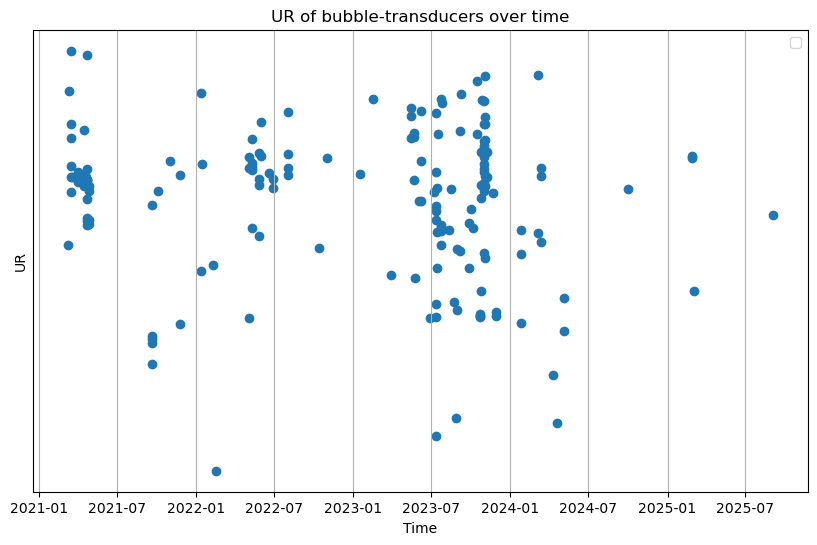

In [22]:
# Code to print scatter plot of droplet/abnormal files vs time
# Time is extracted from the filename. It is the part after the last underscore and before the .mat extension
# Time in filename is in format DDMMMYYYYHHMMSS (e.g., 01Jan2023011230 for 1st Jan 2023, 01:12:30)
import matplotlib.pyplot as plt
from datetime import datetime

def extract_time_from_filename(filename):
    try:
        base_name = os.path.basename(filename)
        time_str = base_name.split('_')[-1].replace('.mat', '')
        return datetime.strptime(time_str, "%d%b%Y%H%M%S")
    except Exception as e:
        print(f"Error extracting time from {filename}: {e}")
        return None
    
def extract_UR_from_file(filename):
    # This function extracts UR value from the mat file.
    # UR is stored as an array ur in the URout struct.
    try:
        mat_data = scipy.io.loadmat(filename)
        if 'URout' in mat_data:
            URout = mat_data['URout']
            if isinstance(URout, np.ndarray) and URout.size > 0:
                # Check if 'ur' is a field in the struct
                if 'ur' in URout.dtype.names:
                    ur_array = URout['ur'][0][0]
                    ur= ur_array[0][0]  # Access the struct object
                    #print(ur)
                    return ur
    except Exception as e:
        print(f"Error extracting UR from {filename}: {e}")
    return None
    
def plot_abnormal_files(abnormal_files):
    times = []
    urs=[]
    for file in abnormal_files:
        time = extract_time_from_filename(file)
        ur= extract_UR_from_file(file)
        if ur is not None and time:
            times.append(time)
            urs.append(ur)
            #print(f"Time: {time}, UR: {ur}")
            
    
    if not times:
        print("No valid times extracted from filenames.")
        return
    
    plt.figure(figsize=(10, 6))
    plt.scatter(times, urs)
    plt.yticks([])  # Hide y-axis
    plt.xlabel('Time')
    plt.ylabel('UR')
    plt.title('UR of bubble-transducers over time')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_abnormal_files(abnormal_files)